In [21]:
!pip install PyTDC


[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: C:\Users\iris0\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [22]:
import time
#import bokeh.io
#import bokeh.plotting
#import numpy as np
#import pandas as pd
#import matplotlib.pyplot as plt
import torch
import torch.nn as nn
#import torch.nn.utils.rnn as rnn_utils
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
from tdc.multi_pred import PPI
#from tqdm import tqdm

ts = time.time()
#bokeh.io.output_notebook()
generator = torch.Generator().manual_seed(12)

In [23]:
data = PPI(name = 'HuRI')
data = data.neg_sample(frac = 1)
split = data.get_split(frac=[0.8, 0, 0.2], seed=12)
train_full = split['train']
valid_full = split['valid']
test_full = split['test']

Found local copy...
Loading...
Done!


In [24]:
max_len = 100

# remove data where protein sequences are longer than max_len amino acids
train = train_full.loc[train_full["Protein1"].str.len()<max_len]
train = train.loc[train["Protein2"].str.len()<max_len]
# valid = valid_full.loc[valid_full["Protein1"].str.len()<max_len]
# valid = valid_full.loc[valid_full["Protein2"].str.len()<max_len]
# test = test_full.loc[test_full["Protein1"].str.len()<max_len]
# test = test_full.loc[test_full["Protein2"].str.len()<max_len]
len(train)

38

In [25]:
train.head(2)

,Protein1_ID,Protein1,Protein2_ID,Protein2,Y
900,ENSG00000008324,MSVAFVPDWLRGKAEVNQETIQRLLEENDQLIRCIVEYQNKGRGNE...,ENSG00000162188,MKGETPVNSTMSIGQARKMVEQLKIEASLCRIKVSKAAADLMTYCD...,1
33541,ENSG00000163202,MSCQQNQQQCQPPPKCPSPKCPPKSPVQCLPPASSGCAPSSGGCGP...,ENSG00000212899,MDCCASRGCSVPTGPATTICSSDKSCRCGVCLPSTCPHTVWLLEPT...,1


In [26]:
amino_acids = 'MLASGVEKITDRPNFQYHCW'
aatoidx = {}
for i, amino_acid in enumerate(amino_acids):
    aatoidx[amino_acid] = i+1

p1 = []
p2 = []
labs = []
for row in range(train.shape[0]):
    r = train.iloc[row]
    protein1 = r['Protein1']
    protein2 = r['Protein2']
    prot1 = []
    prot2 = []
    add = True
    for i in range(max_len):
        if i < len(protein1)-1:
            if protein1[i] in amino_acids:
                prot1.append(aatoidx[protein1[i]])
            else:
                add = False
                break
        else:
            prot1.append(0)
            
        if i < len(protein2)-1:
            if protein2[i] in amino_acids:
                prot2.append(aatoidx[protein2[i]])
            else:
                add = False
                break
        else:
            prot2.append(0)
        
    if add:
        p1.append(torch.tensor(prot1).type(torch.long))
        p2.append(torch.tensor(prot2).type(torch.long))
        labs.append(r['Y'])

p1 = torch.stack(p1)
#p1 = F.one_hot(p1, num_classes=21)[:,:,1:].type(torch.float)
p1 = p1 / 20
p2 = torch.stack(p2)
#p2 = F.one_hot(p2, num_classes=21)[:,:,1:].type(torch.float)
p2 = p2 / 20
labs = torch.tensor(labs).type(torch.float)

In [27]:
class HuRI(Dataset):
    def __init__(self, labs, p1, p2):
        # labs is an (n_samples,)-long torch tensor of 0/1 interaction scores
        # prot1 is an (n_samples, max_len, 20)-shaped torch tensor of one-hot encoded protein 1s
        # prot2 is an (n_samples, max_len, 20)-shaped torch tensor of one-hot encoded protein 2s
        self.labs = labs
        self.p1 = p1
        self.p2 = p2
    
    def __len__(self):
        return self.labs.shape[0]
    
    def __getitem__(self, idx):
        #return (self.p1[idx,:,:], self.p2[idx,:,:]), self.labs[idx]
        label = torch.zeros(2)
        label[self.labs[idx].type(torch.long)] = 1
        return (self.p1[idx,:], self.p2[idx,:]), label.type(torch.float) #self.labs[idx]

In [28]:
class ConvolutionalClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.c = 256
        self.InputConv = nn.Conv1d(2, self.c, 5, padding='valid').to(device)
        self.BasicConv = nn.Conv1d(int(self.c/2), self.c, 5, padding='same').to(device)
        self.EndConv1 = nn.Conv1d(int(self.c/2), 3, 1).to(device)
        self.EndConv2 = nn.Conv1d(3, 2, 1).to(device)
        self.Lin1 = nn.Linear(max_len*2 - 8, 64).to(device)
        self.Lin2 = nn.Linear(64, 2).to(device)
    
    def forward(self, p1, p2):
        x = self.InputConv(torch.stack((p1, p2), dim=1))
        for i in range(20):
            x = self.BasicConv(F.glu(F.layer_norm(x, x.shape[1:]), dim=1)) + x
        x = self.BasicConv(F.glu(F.layer_norm(x, x.shape[1:]), dim=1))
        for i in range(20):
            x = self.BasicConv(F.glu(F.layer_norm(x, x.shape[1:]), dim=1)) + x
        x = F.glu(F.layer_norm(x, x.shape[1:]), dim=1)
        x = self.EndConv1(x)
        x = self.EndConv2(x).flatten(start_dim=1)
        x = F.relu(self.Lin1(F.dropout(x, p=0.4)))
        x = self.Lin2(x)
        return F.softmax(x, dim=1)

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Running with {device}')

#torch.backends.cudnn.benchmark = True
#torch.backends.cudnn.enabled = True

Running with cpu


In [30]:
dataset = HuRI(labs, p1, p2)

train_test = random_split(dataset, [int(labs.shape[0]*0.8), 
                                    labs.shape[0]-int(labs.shape[0]*0.8)],
                          generator=generator)

batch_size = 16
train_loader = DataLoader(train_test[0], batch_size=batch_size, shuffle=True, generator=generator)
test_loader = DataLoader(train_test[1], batch_size=batch_size, shuffle=False, generator=generator)

In [31]:
# Initialize the model and optimizer
model = ConvolutionalClassifier()

optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)

loss_fn = nn.BCELoss(reduction='sum')

In [32]:
num_epochs = 20

train_loss_tracker = torch.zeros(num_epochs)
test_loss_tracker = torch.zeros(num_epochs)

tic = time.time()
#print(f'Setup Time: {tic - ts}')
te = tic

# Train the model
for epoch in range(num_epochs): #tqdm(range(num_epochs)):
    model.train()
    for i, (train_data, train_labels) in enumerate(train_loader):
        # Forward pass
        outputs = model(train_data[0].to(device), train_data[1].to(device)).to(device)
        probs, preds = torch.max(outputs, dim=1)
        train_labels = train_labels.to(device)
        loss = loss_fn(outputs, train_labels)
        train_loss_tracker[epoch] += loss / (int(labs.shape[0]*0.8)*torch.log(torch.tensor(4)))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
           
    model.eval()
    acc = 0
    with torch.no_grad():
        for i, (test_data, test_labels) in enumerate(test_loader):
            outputs = model(test_data[0].to(device), test_data[1].to(device)).to(device)
            test_labels = test_labels.to(device)
            test_loss = loss_fn(outputs, test_labels)
            test_loss_tracker[epoch] += test_loss / \
                    ((labs.shape[0]-int(labs.shape[0]*0.8))*torch.log(torch.tensor(4)))
            ps, preds = torch.max(outputs, dim=1)
            acc += sum(preds == test_labels.argmax()) / (labs.shape[0]-int(labs.shape[0]*0.8))
    
    scheduler.step(acc)

    print(f'Epoch {epoch+1}:\t Accuracy: {round(acc.item()*100, 5)}', end='')
    print(f'\tTrain Loss: {round(train_loss_tracker[epoch].item(), 5)}', end='')
    print(f'\tTest Loss: {round(test_loss_tracker[epoch].item(), 5)}', end='')
    print(f'\tRuntime: {round(time.time()-te, 0)}')
    te = time.time()
    
toc = time.time()
print(f'Training Runtime: {toc-tic}s')

Text(0.5, 1.0, 'Training Set Loss')

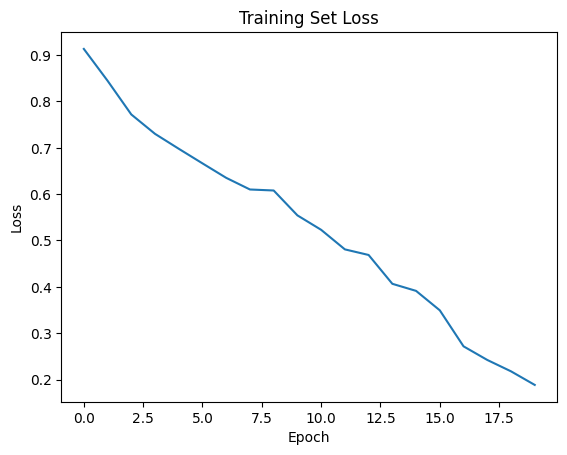

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_loss_tracker.detach().numpy())
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Set Loss")

Text(0.5, 1.0, 'Testing Set Loss')

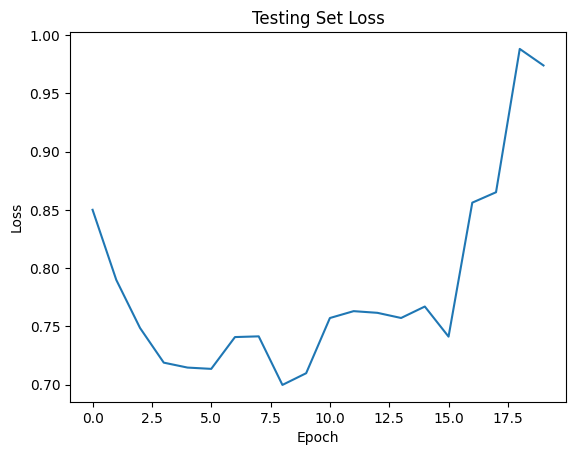

In [ ]:
plt.plot(test_loss_tracker.detach().numpy())
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Testing Set Loss")